## Readings

以下是我用來製作這款NoteBook的資源。我建議您事先閱讀這些內容或者在處理這些材料時閱讀這些內容

* A really good [conceptual overview](http://mccormickml.com/2016/04/19/word2vec-tutorial-the-skip-gram-model/) of word2vec from Chris McCormick 
* [First word2vec paper](https://arxiv.org/pdf/1301.3781.pdf) from Mikolov et al.
* [NIPS paper](http://papers.nips.cc/paper/5021-distributed-representations-of-words-and-phrases-and-their-compositionality.pdf) with improvements for word2vec also from Mikolov et al.
* An [implementation of word2vec](http://www.thushv.com/natural_language_processing/word2vec-part-1-nlp-with-deep-learning-with-tensorflow-skip-gram/) from Thushan Ganegedara
* TensorFlow [word2vec tutorial](https://www.tensorflow.org/tutorials/word2vec)

## Word embeddings

**原因**：
當你處理文本中的單詞時，最終會有**數以萬計**個類預測，每個單詞一個。嘗試對這些單詞進行one hot 編碼 效率非常低，您將有一個元素設置為1，另一個元素設置為0.進入第一個隱藏層的矩陣乘法幾乎將所有結果值設置為零。這是一個巨大的計算浪費。

![one-hot encodings](assets/one_hot_encoding.png)
![](https://pic4.zhimg.com/80/v2-a1a73c063b32036429fbd8f1ef59034b_hd.jpg)

為了解決這個問題並大大提高我們網絡的效率，我們使用了所謂的嵌入embedding。嵌入embedding只是一個完全連接的圖層，就像您之前所見。我們稱這一層為嵌入embedding層，權重為嵌入權重embedding weights。我們通過直接從權重矩陣中獲取隱藏層值來跳過乘法到嵌入層。我們可以這樣做，因為一個one hot 編碼向量與一個矩陣的相乘將返回對應於“開”輸入單元的索引的矩陣的行。

![lookup](assets/lookup_matrix.png)



我們不使用矩陣乘法，而是使用權重矩陣作為查找表。我們將單詞編碼為整數，例如“心臟”編碼為958，“心智”編碼為18094.然後，為了獲得“心臟”的隱藏層值，您只需要嵌入矩陣的第958行。這個過程被稱為**嵌入查找**，隱藏單元的數量是**嵌入維**。

<img src='assets/tokenize_lookup.png' width=500>
 


這裡沒有什麼不可思議的事情發生。嵌入查詢表embedding lookup table 只是一個權重矩陣。嵌入層只是一個隱藏層。查找只是矩陣乘法的一個捷徑，可以把它想成對應表，進入的一個one hot編碼，只會對應到**一個列**。查找表look up table 也像任何權重矩陣一樣受到訓練。

嵌入不僅用於單詞當然。您可以將它們用於您擁有大量課程的任何模型。稱為** Word2Vec **的特定類型的模型使用嵌入層來查找包含語義含義的單詞的向量表示。

## Word2Vec

word2vec算法通過查找代表單詞的向量來找到更有效的表示。這些向量還包含關於單詞的語義信息。在類似的情況下出現的詞語，如“黑色”，“白色”和“紅色”，將具有彼此靠近的向量。有兩種架構可以實現word2vec，CBOW（Continuous Bag-Of-Words）和Skip-gram。

<img src =“assets / word2vec_architectures.png”width =“500”>

在這個實現中，我們將使用skip-gram體系結構，因為它的性能比CBOW好。在這裡，我們傳遞一個單詞並嘗試預測文本中圍繞它的單詞。通過這種方式，我們可以訓練網絡學習表達類似情境中的單詞。
First up, importing packages.

In [23]:
import time
import numpy as np
import tensorflow as tf
import re
from collections import Counter
from wordcloud import WordCloud
import matplotlib.pyplot as plt

Load the [text8 dataset](http://mattmahoney.net/dc/textdata.html), a file of cleaned up Wikipedia articles from Matt Mahoney. The next cell will download the data set to the `data` folder. Then you can extract it and delete the archive file to save storage space.

In [2]:
from urllib.request import urlretrieve
from os.path import isfile, isdir
from tqdm import tqdm
import zipfile

dataset_folder_path = 'data'
dataset_filename = 'text8.zip'
dataset_name = 'Text8 Dataset'

class DLProgress(tqdm):
    last_block = 0

    def hook(self, block_num=1, block_size=1, total_size=None):
        self.total = total_size
        self.update((block_num - self.last_block) * block_size)
        self.last_block = block_num

if not isfile(dataset_filename):
    with DLProgress(unit='B', unit_scale=True, miniters=1, desc=dataset_name) as pbar:
        urlretrieve(
            'http://mattmahoney.net/dc/text8.zip',
            dataset_filename,
            pbar.hook)

if not isdir(dataset_folder_path):
    with zipfile.ZipFile(dataset_filename) as zip_ref:
        zip_ref.extractall(dataset_folder_path)
        
with open('data/text8') as f:
    text = f.read()

## WordCloud
一虧文本裡面文字分佈情況。
PS先說一下喔！這會跑一段時間！

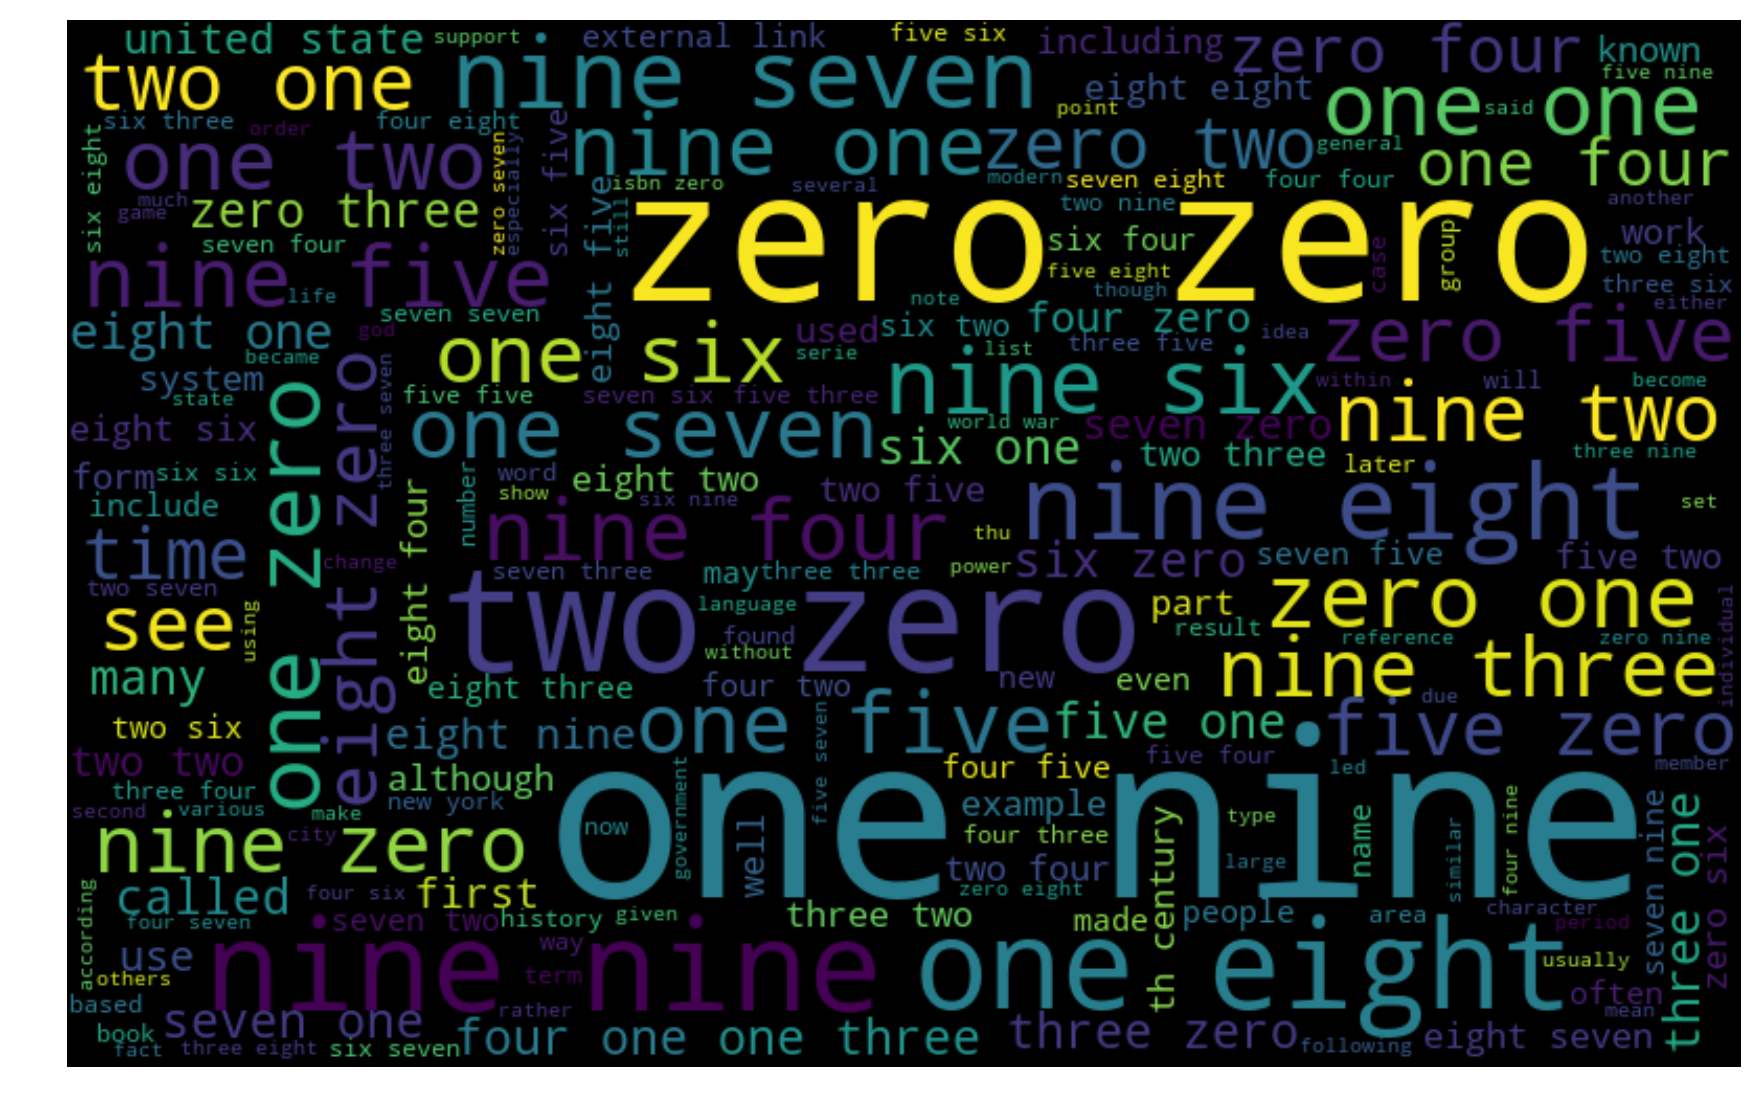

In [29]:
wordcloud = WordCloud(font_path='spooky_font.ttf', width=800, height=500,
                      random_state=21, max_font_size=110).generate(text)
plt.figure(figsize=(15, 12))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

## Preprocessing


在這裡，我正在修改文本以使訓練更加容易。 `preprocess`函數將任何標點符號轉換為標記，所以句點更改為`<PERIOD>`。我還刪除了在數據集中顯示五次或更少次的所有單詞。這將大大減少由於數據中的噪音引起的問題，並改善向量表示的質量。如果你想為這些東西編寫你自己的函數，就去做吧。

In [3]:
def preprocess(text):

    # Replace punctuation with tokens so we can use them in our model
    text = text.lower()
    text = text.replace('.', ' <PERIOD> ')
    text = text.replace(',', ' <COMMA> ')
    text = text.replace('"', ' <QUOTATION_MARK> ')
    text = text.replace(';', ' <SEMICOLON> ')
    text = text.replace('!', ' <EXCLAMATION_MARK> ')
    text = text.replace('?', ' <QUESTION_MARK> ')
    text = text.replace('(', ' <LEFT_PAREN> ')
    text = text.replace(')', ' <RIGHT_PAREN> ')
    text = text.replace('--', ' <HYPHENS> ')
    text = text.replace('?', ' <QUESTION_MARK> ')
    # text = text.replace('\n', ' <NEW_LINE> ')
    text = text.replace(':', ' <COLON> ')
    words = text.split()
    
    # Remove all words with  5 or fewer occurences
    word_counts = Counter(words)
    trimmed_words = [word for word in words if word_counts[word] > 5]

    return trimmed_words

In [4]:
words = preprocess(text)
print(words[:30])

['anarchism', 'originated', 'as', 'a', 'term', 'of', 'abuse', 'first', 'used', 'against', 'early', 'working', 'class', 'radicals', 'including', 'the', 'diggers', 'of', 'the', 'english', 'revolution', 'and', 'the', 'sans', 'culottes', 'of', 'the', 'french', 'revolution', 'whilst']


In [5]:
print("Total words: {}".format(len(words)))
print("Unique words: {}".format(len(set(words))))

Total words: 16680599
Unique words: 63641


在這裡，創建了詞典來將詞彙轉化為整數和倒數，整數轉化為詞彙，這在NLP是很常見的做法。
> **Example**: 
1. Tokenization  - 我們需要將句子分解成獨特的單詞。例如，“我喜歡貓和愛狗”將成為[“我”，“愛”，“貓”，“和”，“狗”]]
2. 索引 - 我們把這些單詞放在類似字典的結構中，並給它們一個索引。例如，{1：“我”，2：“愛”，3：“貓”，4：“和”，5：“狗“}
3. 索引表示法 - 我們可以用索引的形式表示評論中的單詞序列，並將這個索引鍊鍊接到我們的神經網路中。例如，[1, 2, 3, 4, 2, 5]

整數是「按降序排列」`sorted(word_counts, key=word_counts.get, reverse=True)`的，所以最頻繁的單詞（“the”）被賦予整數0，次最頻繁的單詞是1，依此類推。單詞被轉換為整數並存儲在列表`int_words`中。

In [6]:
def create_lookup_tables(words):
    """
    Create lookup tables for vocabulary
    :param words: Input list of words
    :return: A tuple of dicts.  The first dict....
    """
    word_counts = Counter(words)
    sorted_vocab = sorted(word_counts, key=word_counts.get, reverse=True)
    int_to_vocab = {ii: word for ii, word in enumerate(sorted_vocab)}
    vocab_to_int = {word: ii for ii, word in int_to_vocab.items()}

    return vocab_to_int, int_to_vocab

In [7]:
vocab_to_int, int_to_vocab = create_lookup_tables(words)
int_words = [vocab_to_int[word] for word in words]

## Subsampling

過度頻繁的字，在上下文無法提供太多的字，如果我們捨棄部份過頻繁字，可以視為移除部分資料雜訊，有利於快速訓練以及更好地表示。 

Mikolove 使用**subsampling**，每個在訓練的字 $w_i$, 給予綁定的機率去移除

$$ P(w_i) = 1 - \sqrt{\frac{t}{f(w_i)}} $$

$t$ 是臨界值參數， $f(w_i)$ 是頻率， $w_i$ 於全部資料集.


> **Exercise:** 對`int_words`中的單詞執行子採樣。也就是說，通過`int_words`去掉每個字，並給出上面顯示的可能性$P(w_i)$。請注意，$P(w_i)$是一個單詞被丟棄的概率。將子採樣數據分配給`train_words`。

In [8]:
from collections import Counter
import random

threshold = 1e-5
word_counts = Counter(int_words)
total_count = len(int_words)
freqs = {word: count/total_count for word, count in word_counts.items()}

p_drop = {word: 1 - np.sqrt(threshold/freqs[word]) for word in word_counts}

train_words = [word for word in int_words if random.random() < (1 - p_drop[word])]
# train_words 就是要抓出，出現極少的文字

## Making batches

現在我們的數據狀況良好，我們需要將其轉化為適當的形式，將其傳遞到我們的網絡中。通過skip-gram體系結構，對於文本中的每個單詞，我們想要抓住該單詞「周圍」窗口中的所有單詞，其大小 $C$. 

From [Mikolov et al.](https://arxiv.org/pdf/1301.3781.pdf): 

"Since the more distant words are usually less related to the current word than those close to it, we give less weight to the distant words by sampling less from those words in our training examples... If we choose $C = 5$, for each training word we will select randomly a number $R$ in range $< 1; C >$, and then use $R$ words from history and $R$ words from the future of the current word as correct labels."

> **Exercise:** 實現一個函數`get_target`，它接收一個單詞列表，index和一個window size，然後在index 周圍的window中返回一個list of word。請確保使用上述算法，您從窗口中選擇了隨機數字的單詞。

In [9]:
def get_target(words, idx, window_size=5):
    ''' Get a list of words in a window around an index. '''

    R = np.random.randint(1, window_size+1) # 隨機選一個正整數，預設window是5，就是挑1~6中間一個整數
    start = idx - R if (idx - R) > 0 else 0
    stop = idx + R
    target_words = set(words[start:idx] + words[idx+1:stop+1])
    
    return list(target_words)


這是為我們的網絡返回批次的功能。這個想法是它從單詞列表中抓取batch_size單詞。然後，對於每個單詞，它會在窗口中獲取目標單詞。我還沒有找到一種方法來傳遞隨機數目的目標詞，並使其與該體系結構一起工作，為每個輸入 - 目標對創建一行。
BTW，這是一個**generator function**，有助於節省記憶體。

In [10]:
def get_batches(words, batch_size, window_size=5):
    ''' Create a generator of word batches as a tuple (inputs, targets) '''
    
    n_batches = len(words)//batch_size
    
    # only full batches
    words = words[:n_batches*batch_size]
    
    for idx in range(0, len(words), batch_size):
        x, y = [], []
        batch = words[idx:idx+batch_size]
        for ii in range(len(batch)):
            batch_x = batch[ii]
            batch_y = get_target(batch, ii, window_size)
            y.extend(batch_y)
            x.extend([batch_x]*len(batch_y))
        yield x, y

## Building the graph

From [Chris McCormick's blog](http://mccormickml.com/2016/04/19/word2vec-tutorial-the-skip-gram-model/), 我們可以看到我們網絡的總體結構。
![embedding_network](./assets/skip_gram_net_arch.png)

輸入字作為One Hot編碼向量傳入。這將進入隱藏的線性單位層，然後進入softmax層。我們將使用softmax圖層進行正常預測。

這裡的想法是訓練隱藏層權重矩陣來找到我們的單詞的有效表示。我們可以放棄softmax層，因為我們並不真正關心使用這個網絡進行預測。我們只需要嵌入矩陣，以便我們可以在我們從數據集構建的其他網絡中使用它。

我要讓你現在分階段構建圖表。首先，像正常一樣創建`inputs`和`labels` 的 placeholders。


> **Exercise:** 使用`tf.placeholder`分配`inputs`和`labels`。我們將以整數傳遞，因此將數據類型設置為`tf.int32`。我們傳入的批次將有不同的大小，因此將批量大小設置為[ None ]。為了讓事情稍後有用，你需要將`labels`的第二維設置為`None`或`1`。

In [11]:
train_graph = tf.Graph()
with train_graph.as_default():
    inputs = tf.placeholder(tf.int32, [None], name='inputs')
    labels = tf.placeholder(tf.int32, [None, None], name='labels') # 第二維設置為None或1。

## Embedding




Embedding 矩陣大小，是取決於隱藏層。所以，如果有一萬個字，三個跟隱藏神經元，矩陣大小就是 $10,000 \times 300$。記住，我們使用tokenize 的數據來處理我們的輸入，通常是整數，其中標記的數量就是我們詞彙表中單詞的數量


>**Exercise:** Tensorflow為我們提供了一個方便的函數 
[`tf.nn.embedding_lookup`](https://www.tensorflow.org/api_docs/python/tf/nn/embedding_lookup)。你傳入嵌入矩陣和一個整數張量，然後它返回對應於這些整數的矩陣中的行，如果想進一步了解這函數細節可以參考[此篇討論](https://stackoverflow.com/questions/34870614/what-does-tf-nn-embedding-lookup-function-do)。

```
embeddings = tf.constant([[[1,1],[2,2],[3,3],[4,4]],[[11,11],[12,12],[13,13],[14,14]],
                          [[21,21],[22,22],[23,23],[24,24]]])
ids=tf.constant([0,2,1])
embed = tf.nn.embedding_lookup(embeddings, ids, partition_strategy='div')

with tf.Session() as session:
    result = session.run(embed)
    print (result)
```
> 在下面，設置你將使用的嵌入特徵的數量（200是一個好的開始， Word2Vec and GloVe 使用 300 維度去描述一個單字
），創建嵌入矩陣變量，並使用`tf.nn.embedding_lookup`來獲得嵌入張量。對於嵌入矩陣，我建議你使用[`tf.random_uniform`](https://www.tensorflow.org/api_docs/python/tf/random_uniform) 在 -1和1 之間用一個統一的隨機數初始化它。

In [12]:
n_vocab = len(int_to_vocab)
n_embedding = 300 # Number of embedding features 
with train_graph.as_default():
    embedding = tf.Variable(tf.random_uniform((n_vocab, n_embedding), -1, 1)) # 初始值
    embed = tf.nn.embedding_lookup(embedding, inputs)

## Negative sampling



對於我們給網絡的每個例子，我們使用softmax層的輸出來訓練它。這意味著對於每個輸入，即使我們只有一個真實的例子，我們也會對數百萬個權重進行非常小的更改。這使得培訓網絡非常低效。我們可以通過僅更新所有權重的一小部分來近似來自softmax層的損失。我們將更新正確標籤的權重，**但只更新少量不正確的標籤**。 This is called ["negative sampling"](http://papers.nips.cc/paper/5021-distributed-representations-of-words-and-phrases-and-their-compositionality.pdf)。 Tensorflow 有更方便的函式去處理, [`tf.nn.sampled_softmax_loss`](https://www.tensorflow.org/api_docs/python/tf/nn/sampled_softmax_loss)。

> **Exercise:** 下面，為softmax圖層創建權重和偏差。 使用 [tf.nn.sampled_softmax_loss](https://www.tensorflow.org/api_docs/python/tf/nn/sampled_softmax_loss)計算損失，這是在許多「類別」上訓練softmax分類器的更快方法。請務必閱讀文檔以了解它的工作原理。

```
tf.nn.sampled_softmax_loss(
    weights,
    biases,
    labels,
    inputs,
    num_sampled,
    num_classes,
    num_true=1,
    sampled_values=None,
    remove_accidental_hits=True,
    partition_strategy='mod',
    name='sampled_softmax_loss',
    seed=None
)
```

In [13]:
# Number of negative labels to sample
n_sampled = 100
with train_graph.as_default():
    softmax_w = tf.Variable(tf.truncated_normal((n_vocab, n_embedding), stddev=0.1)) # 初始值
    softmax_b = tf.Variable(tf.zeros(n_vocab)) # 初始值
    
    # Calculate the loss using negative sampling
    loss = tf.nn.sampled_softmax_loss(softmax_w, softmax_b, 
                                      labels, embed,
                                      n_sampled, n_vocab)

    cost = tf.reduce_mean(loss)
    optimizer = tf.train.AdamOptimizer().minimize(cost)

## Validation

這段代碼來自於Thushan Ganegedara的實現。在這裡，我們將選擇一些常用詞彙和少數不常見的詞彙。然後，我們會列出最接近他們的單詞。這是一個很好的方法來檢查我們的嵌入表是否將具有相似語義含義的單詞分組在一起。

In [14]:
with train_graph.as_default():
    ## From Thushan Ganegedara's implementation
    valid_size = 16 # Random set of words to evaluate similarity on.
    valid_window = 100
    # pick 8 samples from (0,100) and (1000,1100) each ranges. lower id implies more frequent 
    valid_examples = np.array(random.sample(range(valid_window), valid_size//2))
    valid_examples = np.append(valid_examples, 
                               random.sample(range(1000,1000+valid_window), valid_size//2))

    valid_dataset = tf.constant(valid_examples, dtype=tf.int32)
    
    # 據評估相似性，就是相似語義含義的單詞分組在一起，我們使用 cosine distance 以下是作法代碼
    norm = tf.sqrt(tf.reduce_sum(tf.square(embedding), 1, keep_dims=True))
    normalized_embedding = embedding / norm
    valid_embedding = tf.nn.embedding_lookup(normalized_embedding, valid_dataset)
    similarity = tf.matmul(valid_embedding, tf.transpose(normalized_embedding))

In [15]:
# If the checkpoints directory doesn't exist:
!mkdir checkpoints

mkdir: cannot create directory ‘checkpoints’: File exists


In [16]:
epochs = 10
batch_size = 1000
window_size = 10

with train_graph.as_default():
    saver = tf.train.Saver()

with tf.Session(graph=train_graph) as sess:
    iteration = 1
    loss = 0
    sess.run(tf.global_variables_initializer())

    for e in range(1, epochs+1):
        batches = get_batches(train_words, batch_size, window_size)
        start = time.time()
        for x, y in batches:
            
            feed = {inputs: x,
                    labels: np.array(y)[:, None]}
            train_loss, _ = sess.run([cost, optimizer], feed_dict=feed)
            
            loss += train_loss
            
            if iteration % 100 == 0: 
                end = time.time()
                print("Epoch {}/{}".format(e, epochs),
                      "Iteration: {}".format(iteration),
                      "Avg. Training loss: {:.4f}".format(loss/100),
                      "{:.4f} sec/batch".format((end-start)/100))
                loss = 0
                start = time.time()
            
            if iteration % 1000 == 0:
                # note that this is expensive (~20% slowdown if computed every 500 steps)
                sim = similarity.eval()
                for i in range(valid_size):
                    valid_word = int_to_vocab[valid_examples[i]]
                    top_k = 8 # number of nearest neighbors
                    nearest = (-sim[i, :]).argsort()[1:top_k+1]
                    log = 'Nearest to %s:' % valid_word
                    for k in range(top_k):
                        close_word = int_to_vocab[nearest[k]]
                        log = '%s %s,' % (log, close_word)
                    print(log)
            
            iteration += 1
    save_path = saver.save(sess, "checkpoints/text8.ckpt")
    embed_mat = sess.run(normalized_embedding)

Epoch 1/10 Iteration: 100 Avg. Training loss: 5.8092 0.0349 sec/batch
Epoch 1/10 Iteration: 200 Avg. Training loss: 5.7341 0.0277 sec/batch
Epoch 1/10 Iteration: 300 Avg. Training loss: 5.6259 0.0298 sec/batch
Epoch 1/10 Iteration: 400 Avg. Training loss: 5.6925 0.0275 sec/batch
Epoch 1/10 Iteration: 500 Avg. Training loss: 5.6294 0.0272 sec/batch
Epoch 1/10 Iteration: 600 Avg. Training loss: 5.6753 0.0282 sec/batch
Epoch 1/10 Iteration: 700 Avg. Training loss: 5.6117 0.0267 sec/batch
Epoch 1/10 Iteration: 800 Avg. Training loss: 5.6765 0.0273 sec/batch
Epoch 1/10 Iteration: 900 Avg. Training loss: 5.5286 0.0274 sec/batch
Epoch 1/10 Iteration: 1000 Avg. Training loss: 5.5241 0.0273 sec/batch
Nearest to four: measuring, mai, distressed, regard, hideous, solidify, dubliners, ww,
Nearest to between: fulham, fostering, miyagi, arista, trimmed, osf, solway, texts,
Nearest to one: avenue, nine, besieges, utub, vashem, snell, gautama, photorealism,
Nearest to were: diadem, paparizou, remo, br

Restore the trained network if you need to:

In [17]:
with train_graph.as_default():
    saver = tf.train.Saver()

with tf.Session(graph=train_graph) as sess:
    saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    embed_mat = sess.run(embedding)

INFO:tensorflow:Restoring parameters from checkpoints/text8.ckpt


## Visualizing the word vectors

下面我們將使用T-SNE來可視化我們的高維詞彙向量如何聚集在一起。 T-SNE用於將這些向量投影到兩個維度，同時保留局部結構。 Check out [this post from Christopher Olah](http://colah.github.io/posts/2014-10-Visualizing-MNIST/) 了解更多關於T-SNE和其他可視化高維數據的方法。

In [18]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

In [19]:
viz_words = 500
tsne = TSNE()
embed_tsne = tsne.fit_transform(embed_mat[:viz_words, :])

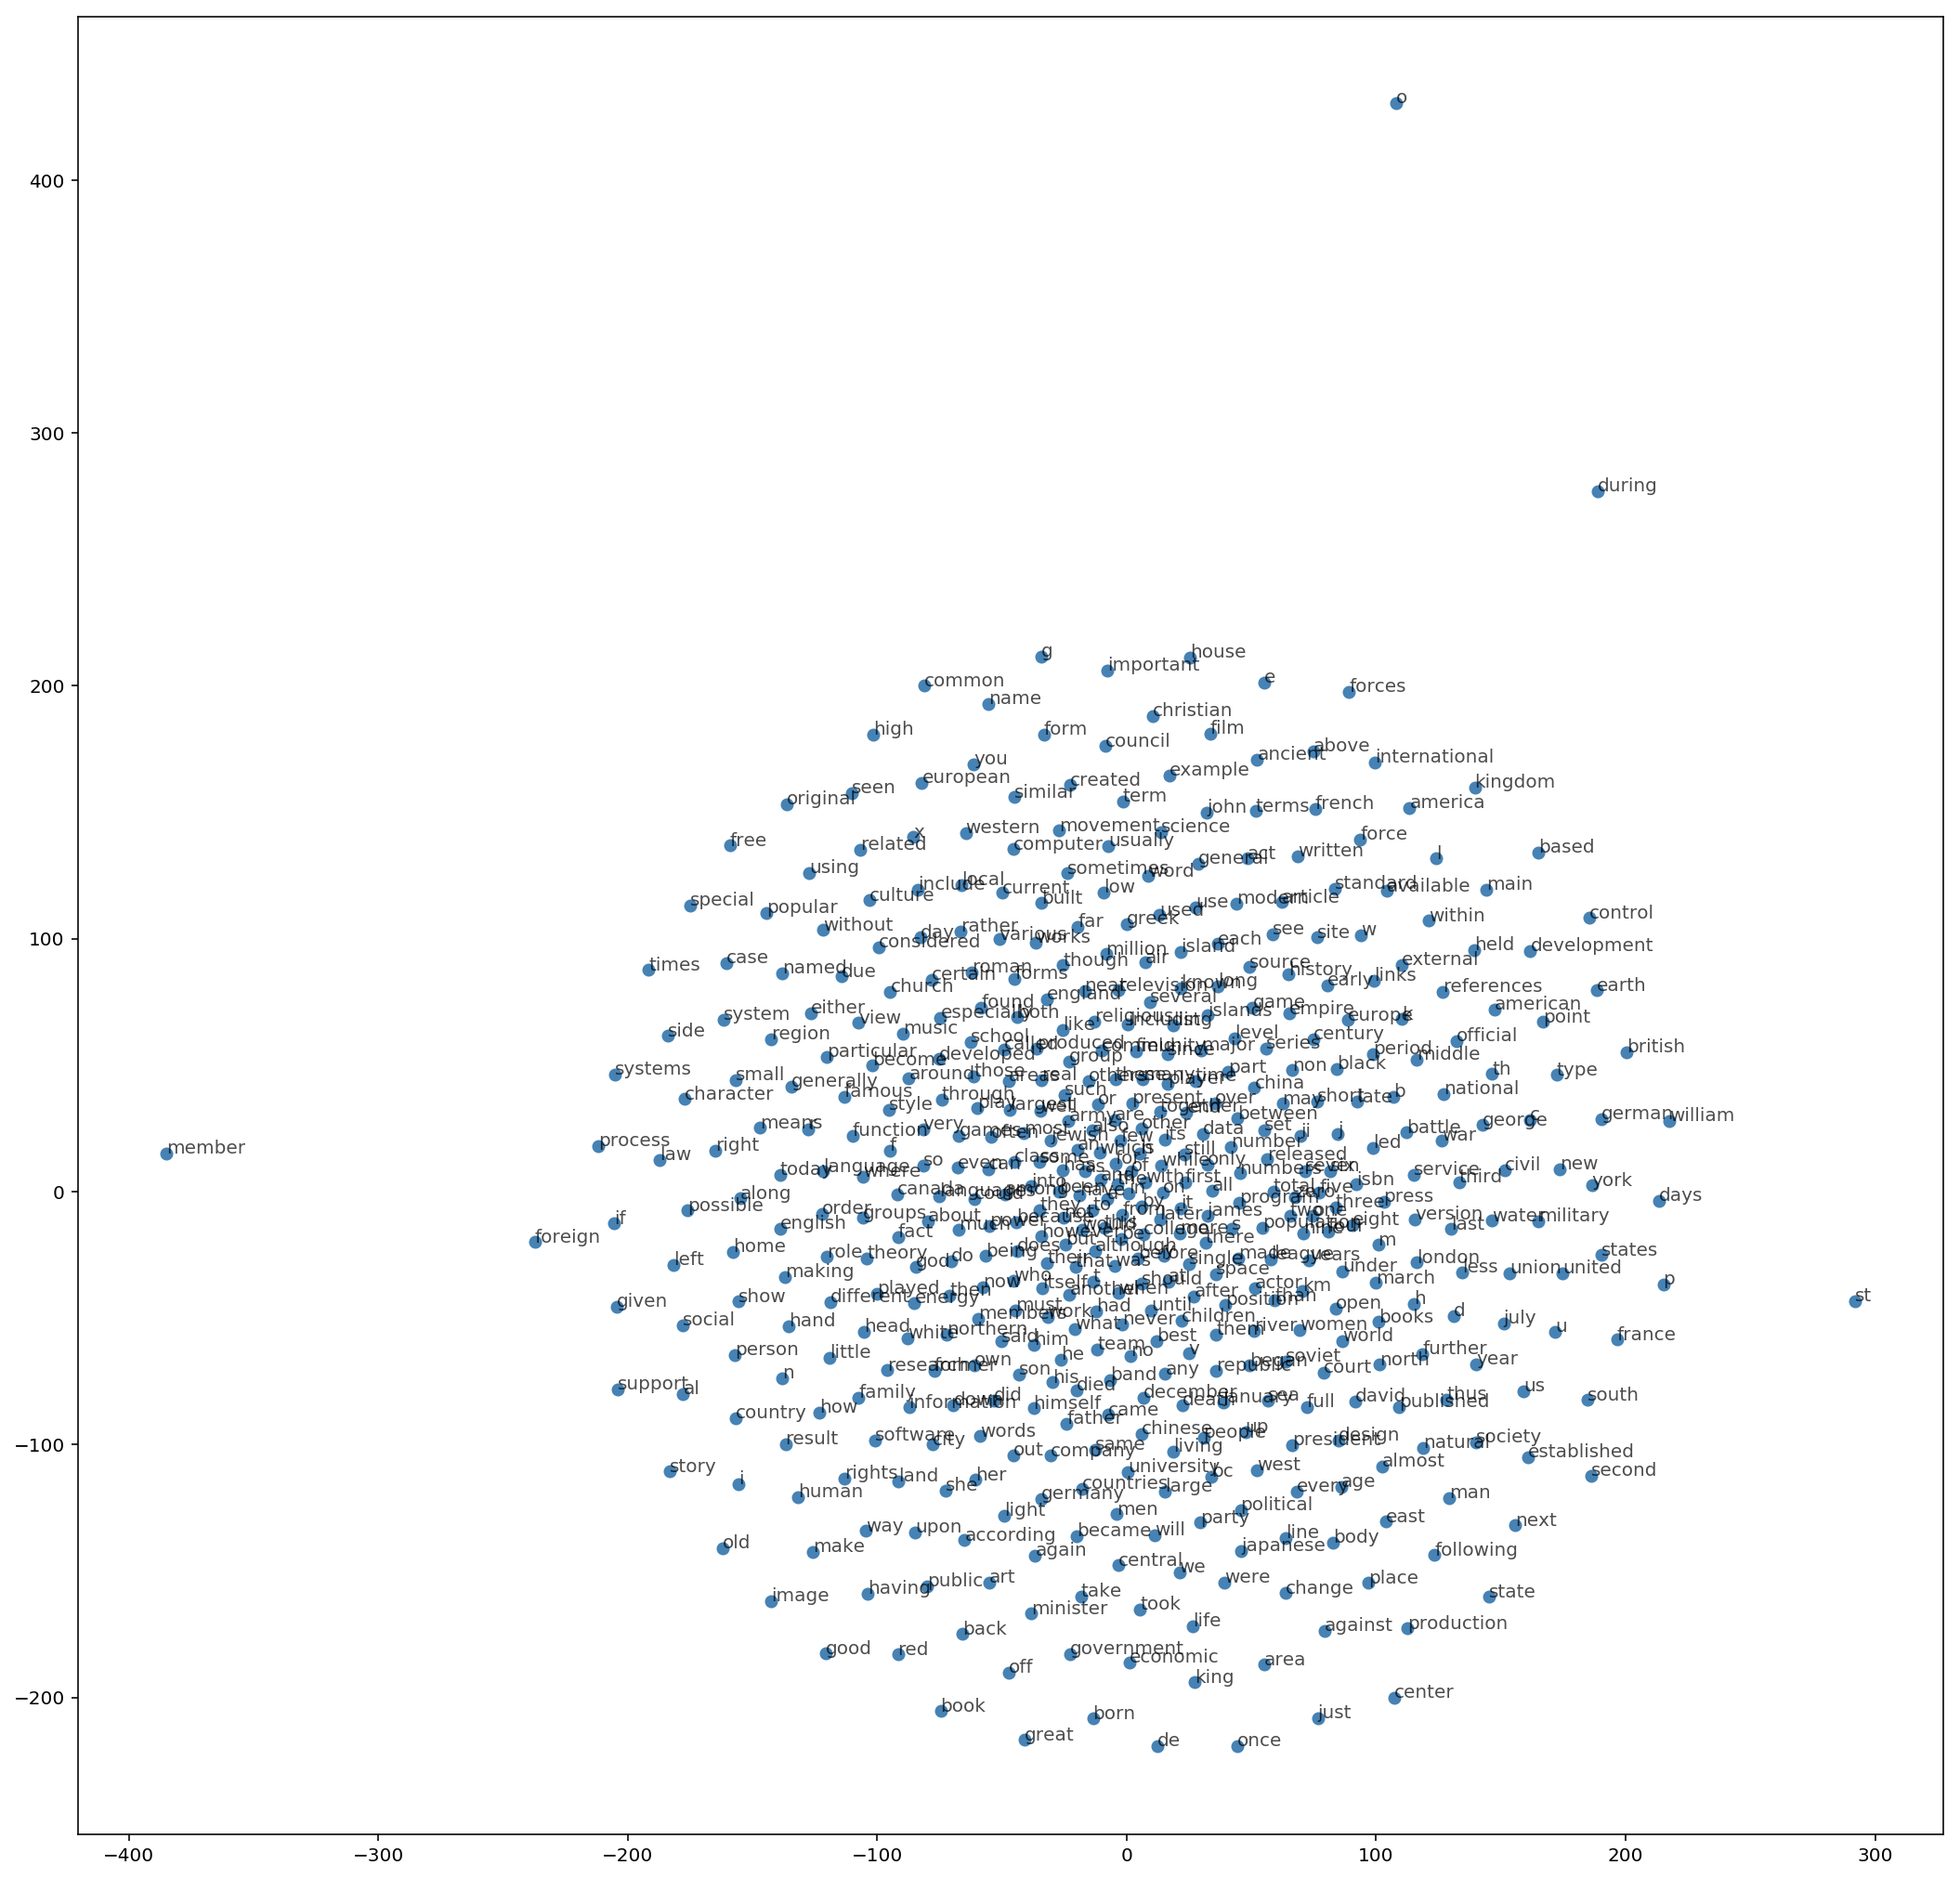

In [21]:
fig, ax = plt.subplots(figsize=(18, 18))
for idx in range(viz_words):
    plt.scatter(*embed_tsne[idx, :], color='steelblue')
    plt.annotate(int_to_vocab[idx], (embed_tsne[idx, 0], embed_tsne[idx, 1]), alpha=0.7)